In [2]:
### Load necessary libraries

# plotting
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


### Load dataset

In [3]:
fdata = pd.read_csv('./Lab1_Decomposition_v5/Unemployment.dat', delimiter=", ")
fdata.head()

/tmp/ipykernel_13141/2043934750.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  fdata = pd.read_csv('./Lab1_Decomposition_v5/Unemployment.dat', delimiter=", ")


,DATE,TOTAL
0,01/01/2010,4048493
1,01/02/2010,4130625
2,01/03/2010,4166613
3,01/04/2010,4142425
4,01/05/2010,4066202


### Explore the data

In [4]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    156 non-null    object
 1   TOTAL   156 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


### Making the 'DATE' column a datetime type

In [5]:
fdata["DATE"] = pd.to_datetime(fdata["DATE"], format="%d/%m/%Y")
fdata.head()

,DATE,TOTAL
0,2010-01-01,4048493
1,2010-02-01,4130625
2,2010-03-01,4166613
3,2010-04-01,4142425
4,2010-05-01,4066202


In [6]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    156 non-null    datetime64[ns]
 1   TOTAL   156 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


### Creating a Temporal Index

The temporal ordering of the data is so important that it is often used as the index of the dataframe, We can achieve this as follows (`MS` stands for Month Start):


In [7]:
fdata.set_index('DATE', inplace=True)
fdata.index.freq = 'MS'
fdata.head()

,TOTAL
DATE,
2010-01-01,4048493
2010-02-01,4130625
2010-03-01,4166613
2010-04-01,4142425
2010-05-01,4066202


### Silent missing values: time gaps in the data

The following issue we are going to address is a particular problem with time series data. As we have said, the temporal structure of the data is essential. This means that the absence of a data point at a certain time is a piece of information in itself. We call this a **time gap** in the series and it can easily go unnoticed at first sight. But such time gaps can cause problems in the analysis downstream, as some models will simply be unable to handle them. It is important to get in the habit of detecting time gaps and dealing with them.


We can do that by first creating a sequence of time instants with the same frequency as our time series but without time gaps. We call it a **full range** below. We do this using the pandas function [`date_range`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html). 

We then simply compare that sequence with the index of the time series:

In [8]:
# Find start and end date of the rime series
start_date = fdata.index.min()
end_date = fdata.index.max()
print(start_date, end_date)

# Generate a full range of months
full_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS' ensures month start
full_range[:5], full_range[-5:]

2010-01-01 00:00:00 2022-12-01 00:00:00


(DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
                '2010-05-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
                '2022-12-01'],
               dtype='datetime64[ns]', freq='MS'))

If the `missing_months` variable below is not empty, it means that we have time gaps in the data. In this case there are no time gaps.

In [9]:
missing_months = full_range.difference(fdata.index)
missing_months

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

If there were time gaps the code below would fill the other variables as missing values (`NaN`), which we can then deal with later on.

In [10]:
fdata = fdata.reindex(full_range)
fdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2010-01-01 to 2022-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TOTAL   156 non-null    int64
dtypes: int64(1)
memory usage: 2.4 KB


We can now look for the missing values in the `TOTAL` column. 

In [11]:
fdata.isna().sum()

TOTAL    0
dtype: int64

There are no missing values in this case. Later we will see how to deal with missing values when they do occur.

### Time plot for the time series:

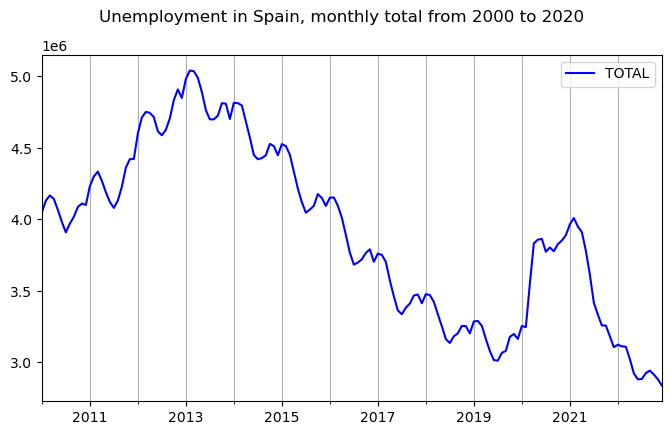

In [12]:
fig, ax = plt.subplots()
fdata.plot(figsize=(8,4.5), c="blue", ax= ax)
fig.suptitle('Unemployment in Spain, monthly total from 2000 to 2020')
ax.grid(visible=True, which='Both', axis='x')
plt.show();plt.close()

### Decomposition methods

In [13]:
fdata

,TOTAL
2010-01-01,4048493
2010-02-01,4130625
2010-03-01,4166613
2010-04-01,4142425
2010-05-01,4066202
...,...
2022-08-01,2924240
2022-09-01,2941919
2022-10-01,2914892
2022-11-01,2881380


This is how to do an additive decomposition:

In [14]:
fdata_dcmp_add = seasonal_decompose(fdata['TOTAL'], model='additive')

And now we can look at the different components of the decomposition. Beginning with the trend component:

In [15]:
fdata_dcmp_add.trend.head(10)

2010-01-01             NaN
2010-02-01             NaN
2010-03-01             NaN
2010-04-01             NaN
2010-05-01             NaN
2010-06-01             NaN
2010-07-01    4.068360e+06
2010-08-01    4.082992e+06
2010-09-01    4.096979e+06
2010-10-01    4.109229e+06
Freq: MS, Name: trend, dtype: float64

Note the **pure periodicity** in the seasonal component. This is a characteristic of this **classical decomposition**:

In [16]:
fdata_dcmp_add.seasonal.head(24)

2010-01-01     80842.168403
2010-02-01    107996.734375
2010-03-01    118956.321181
2010-04-01     78346.404514
2010-05-01        30.897569
2010-06-01    -82320.470486
2010-07-01   -136268.862847
2010-08-01   -105383.043403
2010-09-01    -75046.296875
2010-10-01      5818.828125
2010-11-01     23309.345486
2010-12-01    -16282.026042
2011-01-01     80842.168403
2011-02-01    107996.734375
2011-03-01    118956.321181
2011-04-01     78346.404514
2011-05-01        30.897569
2011-06-01    -82320.470486
2011-07-01   -136268.862847
2011-08-01   -105383.043403
2011-09-01    -75046.296875
2011-10-01      5818.828125
2011-11-01     23309.345486
2011-12-01    -16282.026042
Freq: MS, Name: seasonal, dtype: float64

And we can get a nice graphical representation of the decomposition as follows:

<Figure size 640x480 with 0 Axes>

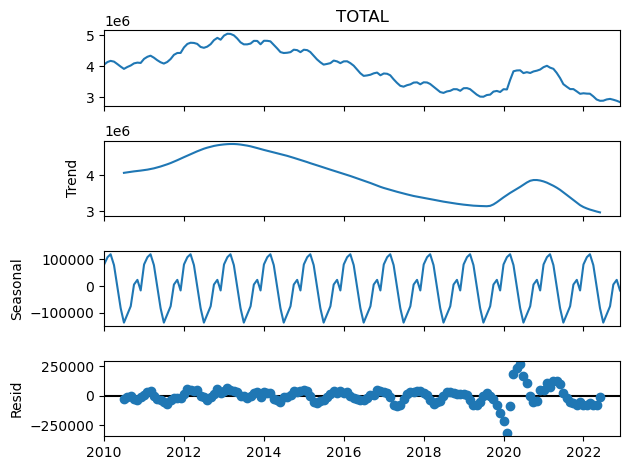

In [17]:
plt.figure()
fdata_dcmp_add.plot()
plt.show();plt.close()